In [1]:
# dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from collections import defaultdict

In [2]:
# reflect tables into SQLAlchemy ORM

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

database_path = "/Users/kinlaydenning/Documents/bootcamp2022/week_10_advanced_database_storage_and_retrieval/sqlalchemy-challenge/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [3]:
# create an inspector and connect to engine

inspector = inspect(engine)

# return table names using inspector
inspector.get_table_names()


['measurement', 'station']

In [4]:
# Using the inspector to print the column names within the measurement table and station table
measurement_columns = inspector.get_columns('measurement')
print('----------Measurement Table------------')
for column in measurement_columns:
    print(column["name"], column["type"])

print('----------Station Table------------')
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])


----------Measurement Table------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------Station Table------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# Reflect database into ORM class
base = automap_base()
base.prepare(engine, reflect=True)
measurement = base.classes.measurement
station = base.classes.station

# create a session
session = Session(engine)

In [6]:
## Exploratory Climate Analysis:

    # Find the last point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

In [25]:
# query date and precipitation and store to dataframe
    # find start date
end_date = dt.date(2017, 8 ,23)
start_date = end_date - dt.timedelta(days=365)


d = [measurement.date,
measurement.prcp]

prcp_query = session.query(*d).\
    filter(func.strftime("%Y-%m-%d", measurement.date) > start_date).\
    order_by(measurement.date).all()
prcp_dict = {}
prcp_dict['date'] = []
prcp_dict['precipitation'] = []
for date, prcp in prcp_query:
    if type(prcp) == float:
        prcp_dict['date'].append(date)
        prcp_dict['precipitation'].append(prcp)

prcp_df = pd.DataFrame(prcp_dict).set_index('date')
prcp_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


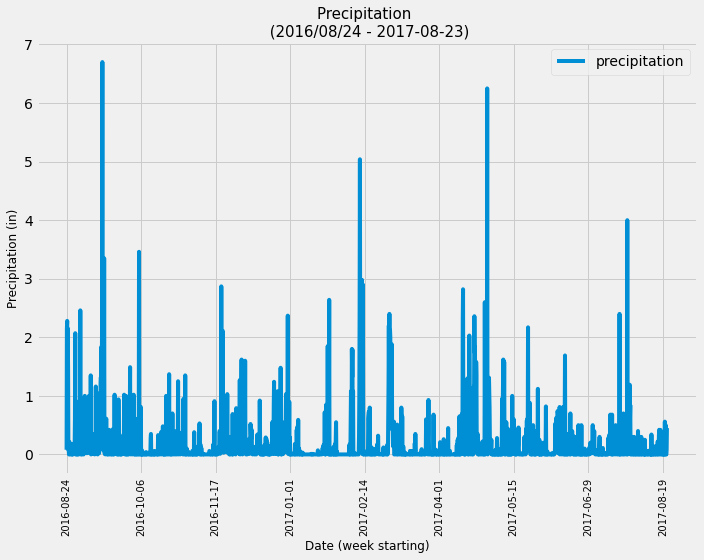

In [26]:
# plot precipitation data as bar chart

prcp_df.plot(figsize=(10,8))
plt.locator_params(axis='x', nbins=16)
plt.tick_params(axis='x')
plt.xticks(fontsize=10, rotation=90)
plt.title("Precipitation \n (2016/08/24 - 2017-08-23)", fontsize=15)
plt.xlabel("Date (week starting)", fontsize=12)
plt.ylabel("Precipitation (in)", fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
# summary statistics
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [37]:
## Station Analysis

# most active stations
station_data = [station.name,
            func.count(station.name)]

station_query = session.query(*station_data).\
    filter(measurement.station == station.station).\
        group_by(station.name).\
        order_by(func.count(station.name).desc()).all()
station_df = pd.DataFrame(station_query)
station_df

,0,1
0,"WAIHEE 837.5, HI US",2772
1,"WAIKIKI 717.2, HI US",2724
2,"KANEOHE 838.1, HI US",2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,"MANOA LYON ARBO 785.2, HI US",2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,"PEARL CITY, HI US",1372
8,"UPPER WAHIAWA 874.3, HI US",511


In [40]:
# highest temp, lowest temp, ave temp most active station

active_station_data = [station.name,
                    func.avg(measurement.tobs),
                    func.max(measurement.tobs),
                    func.min(measurement.tobs)]

active_station_query = session.query(*active_station_data).\
    filter(measurement.station == station.station).\
    filter(station.name == "WAIHEE 837.5, HI US").\
    group_by(measurement.station).all()
active_station_query


[('WAIHEE 837.5, HI US', 71.66378066378067, 85.0, 54.0)]

In [41]:
# temp observation data for most active station

date_temp_query = session.query(measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", measurement.date) > start_date).\
    filter(measurement.station == 'USC00519281').all()
list_tobs = list(np.ravel(date_temp_query))
temp_st_df = pd.DataFrame({"Tobs": list_tobs})

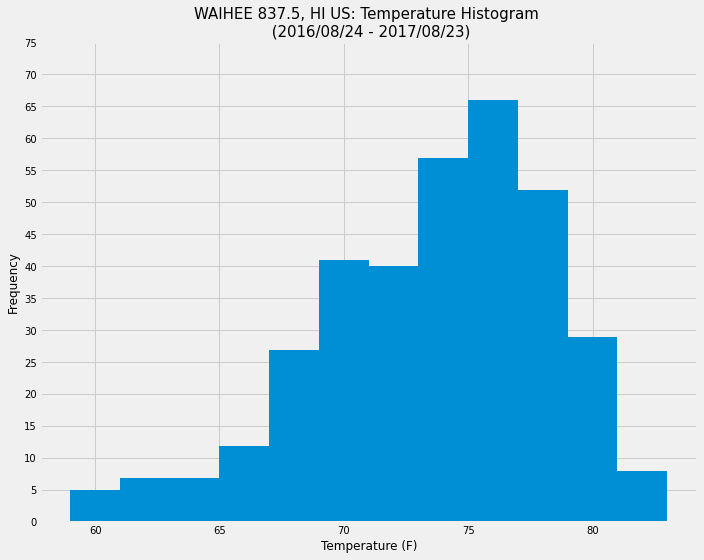

In [42]:
# histogram

temp_st_df.hist(column='Tobs', bins=12, figsize=(10,8))
plt.title("WAIHEE 837.5, HI US: Temperature Histogram \n (2016/08/24 - 2017/08/23)", fontsize=15)
plt.xlabel("Temperature (F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0, 80, step=5), fontsize=10)
plt.tight_layout()
plt.show()